## Calculating Implied Volatility using Black-Scholes

In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import fsolve
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [2]:
def calculate_implied_volatility(S, K, T, r, price):
    def f(sigma):
        d1 = (1 / (sigma * T ** 0.5)) * (np.log(S / K) + (r + (sigma ** 2) / 2) * T)
        d2 = d1 - sigma * T ** 0.5
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2) - price

    return fsolve(f, 0.5, maxfev=1000)[0]


Current AAPL stock price: 171.61000061035156
Strike Price: 170.0  Implied Volatility: 0.35281076472345707  Market Prx:  2.24
Strike Price: 172.5  Implied Volatility: 0.33967660230296065  Market Prx:  0.835
Strike Price: 175.0  Implied Volatility: 0.3549056610822745  Market Prx:  0.245
Strike Price: 177.5  Implied Volatility: 0.3913127821937329  Market Prx:  0.07500000000000001
Strike Price: 180.0  Implied Volatility: 0.45414038204395324  Market Prx:  0.035
Strike Price: 182.5  Implied Volatility: 0.5363567305766707  Market Prx:  0.025
Strike Price: 185.0  Implied Volatility: 0.5970174662794655  Market Prx:  0.015
Strike Price: 187.5  Implied Volatility: 0.6896331292441494  Market Prx:  0.015


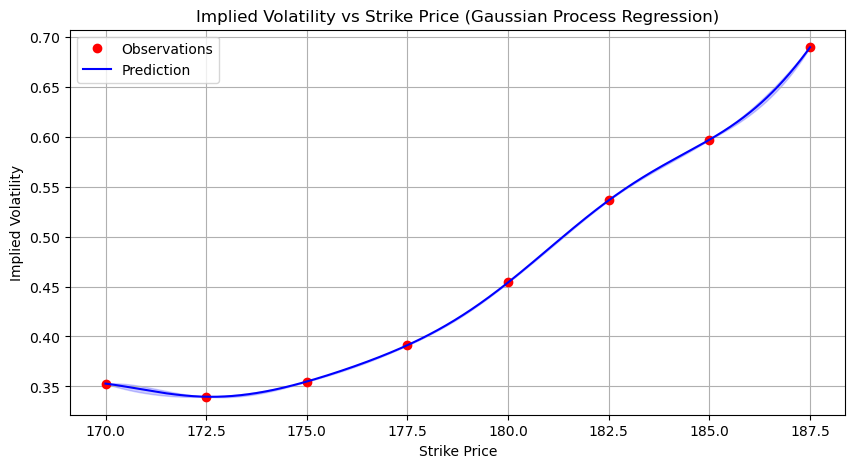

In [3]:
def main():
    # Fetch stock data for AAPL
    stock = yf.Ticker("AAPL")
    current_price = stock.history(period='1d').iloc[-1]['Close']
    print("Current AAPL stock price:", current_price)

    # Specify expiry date as a string
    expiry_date = "2024-03-15"

    # Calculate time to expiry
    from datetime import datetime
    today = datetime.now()
    expiry_date_obj = datetime.strptime(expiry_date, "%Y-%m-%d")
    time_to_expiry = (expiry_date_obj - today).days / 366

    # Fetch call options data for AAPL with the specified expiry date
    options = stock.option_chain(expiry_date).calls

    # Filter options with open interest more than 10000 and ask price greater than 0
    options = options[(options['openInterest'] > 10000) & (options['bid'] > 0)]

    # Calculate implied volatility for filtered options
    implied_volatilities = []
    for index, option in options.iterrows():
        strike_price = option['strike']
        option_price = (option['ask'] + option['bid']) / 2
        risk_free_rate = 0.055  # Assume a risk-free rate for calculation
        implied_volatility = calculate_implied_volatility(current_price, strike_price, time_to_expiry, risk_free_rate, option_price)
        implied_volatilities.append(implied_volatility)
        print("Strike Price:", strike_price, " Implied Volatility:", implied_volatility, " Market Prx: ", option_price)

    # Perform Gaussian Process Regression
    X = options[['strike']].values
    y = np.array(implied_volatilities)

    # Gaussian Process Regression
    kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X, y)

    # Predict using the Gaussian Process model
    x_pred = np.linspace(X.min()-0*5, X.max()+0*5, 1000).reshape(-1, 1)
    y_pred, sigma = gp.predict(x_pred, return_std=True)

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(X, y, 'ro', label='Observations')
    plt.plot(x_pred, y_pred, 'b-', label='Prediction')
    plt.fill_between(x_pred.flatten(), (y_pred - 1.96 * sigma).flatten(), (y_pred + 1.96 * sigma).flatten(), alpha=0.2, color='blue')
    plt.title("Implied Volatility vs Strike Price (Gaussian Process Regression)")
    plt.xlabel("Strike Price")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
